In [1]:
import torch
import torchvision


import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.animation as animation


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(9216, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         output = F.log_softmax(x, dim=1)
#         return output

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        self.dropout1 = nn.Dropout(0.25)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
def train(model, device, train_loader, optimizer, epoch,log_interval=10,dry_run=False,plot=False,save_weights=False):
    model.train()
    
#     if plot:


    if save_weights:
        # n_weights x training_steps
        
        weights, biases = model.state_dict().items()
        n_weights = weights[1][5].cpu().shape[0]
        n_training_steps = len(train_loader)
        n_classes = 10
        
        weights_out = np.zeros((n_classes,n_weights, n_training_steps))
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break
                
        if save_weights:
            weights, biases = model.state_dict().items()
            #Get weights of layer 1 for neuron 5
            
#             weights[1].cpu().numpy()
            
            
            weights_out[...,batch_idx] = weights[1].cpu().numpy()
            
    if save_weights:
        return weights_out
    

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [5]:
# device = torch.device("cuda")
device = torch.device("cpu")

In [9]:
batch_size = 16
test_batch_size = 1
lr = .1
gamma = .7
epochs = 1
log_interval = 10000
save_model = True

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': False}

train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [7]:
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)

dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)


def transf_data_set(dataset):
    new_dataset = []
    for x,y in dataset:
        new_dataset.append((x.flatten(),y))
        
    return new_dataset

d1 = transf_data_set(dataset1)
d2 = transf_data_set(dataset2)



In [10]:
train_loader = torch.utils.data.DataLoader(d1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(d2, **test_kwargs)

model = Net().to(device)

num_models = 30

# optimizer = optim.Adadelta(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

weight_data = None

for model_i in range(num_models):
    
    model = Net().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    for epoch in range(1, epochs + 1):
        weights_temp = train(model, device, train_loader, optimizer, epoch, log_interval,save_weights=True)
        test(model, device, test_loader)
#         scheduler.step()
    if model_i == 0:
        weights_data = weights_temp[np.newaxis, ...]
    else:
        weights_data = np.vstack([weights_data, weights_temp[np.newaxis, ...]])



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.671930

Test set: Average loss: 0.3997, Accuracy: 8803/10000 (88%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331722

Test set: Average loss: 0.3699, Accuracy: 8912/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.445591

Test set: Average loss: 0.3559, Accuracy: 8921/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.622983

Test set: Average loss: 0.3901, Accuracy: 8810/10000 (88%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.522891

Test set: Average loss: 0.3667, Accuracy: 8911/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.726775

Test set: Average loss: 0.3679, Accuracy: 8893/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333262

Test set: Average loss: 0.3628, Accuracy: 8940/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.611077

Test set: Average loss: 0.3536, Accuracy: 8935/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.402909

Test set: Average loss: 0.3702, Accuracy: 8887/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.412876



In [11]:
print(weights_data.shape)

(30, 10, 784, 3750)


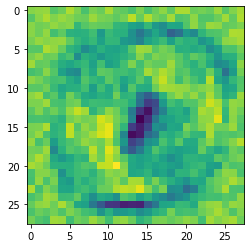

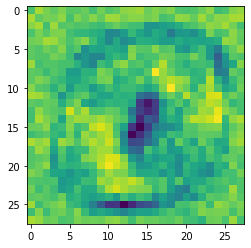

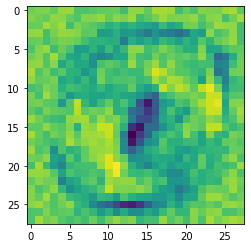

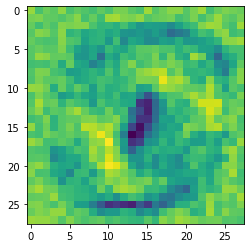

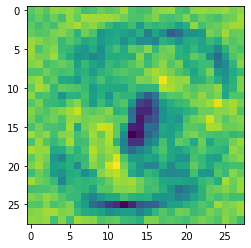

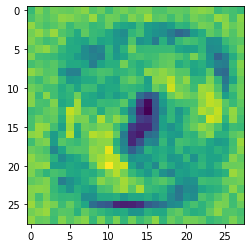

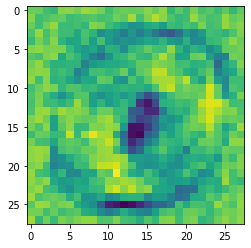

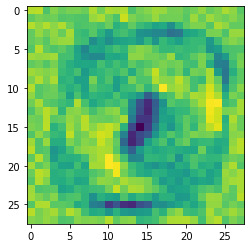

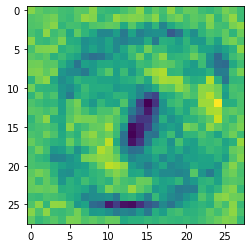

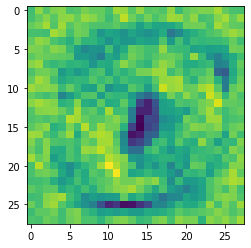

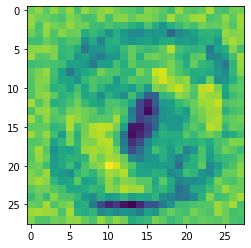

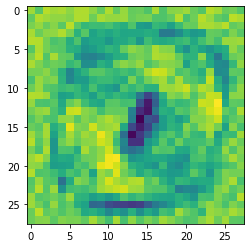

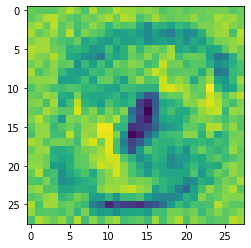

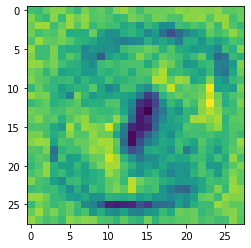

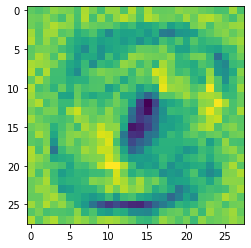

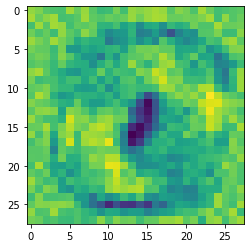

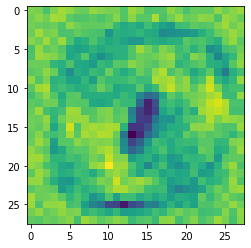

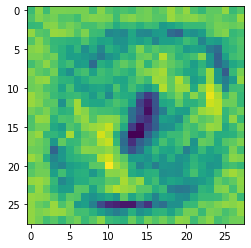

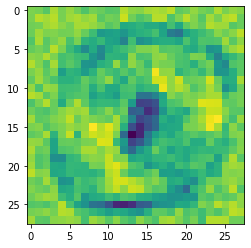

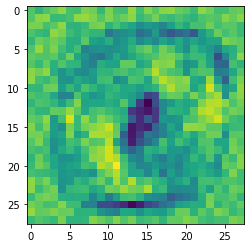

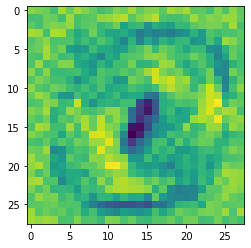

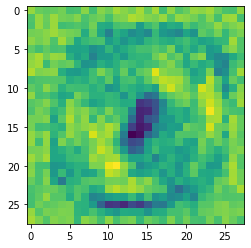

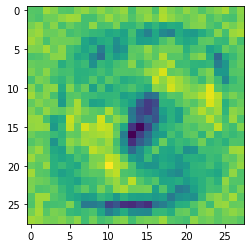

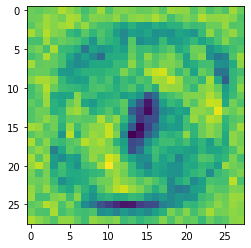

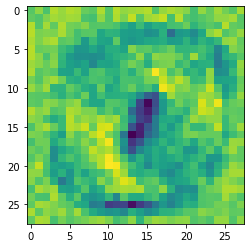

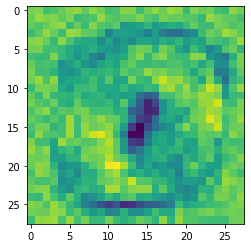

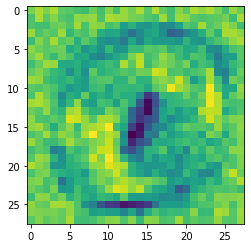

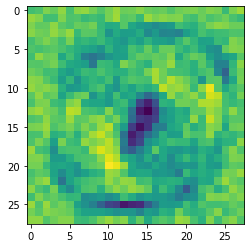

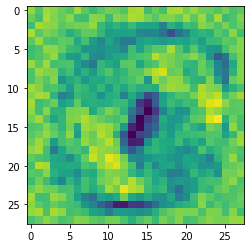

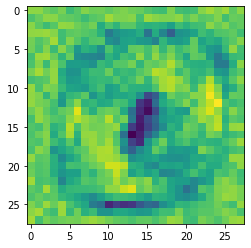

In [44]:

for model_i in range(num_models):
    plt.imshow(weights_data[model_i,0,:,-1].reshape((28,28)))
    plt.show()

In [ ]:
%matplotlib inline

for i in range(10):
    print(i)
    plt.imshow((weights[1][i].cpu().reshape((28,28))))
    plt.show()
    
    
for i in range(10):
    print((d1[i][1]))
    plt.imshow(d1[i][0].cpu().reshape((28,28)))
    plt.show()

# Time for TCA
We will attempt to see learning for each neuron's receptive field through 1 epoch

In [18]:
!pip3 install git+https://github.com/ahwillia/tensortools

  Cloning https://github.com/ahwillia/tensortools to /private/var/folders/3x/wct_hg3s15b1s1l_33w8q9vw0000gn/T/pip-req-build-atr3jeoa
  Running command git clone -q https://github.com/ahwillia/tensortools /private/var/folders/3x/wct_hg3s15b1s1l_33w8q9vw0000gn/T/pip-req-build-atr3jeoa
     |████████████████████████████████| 71kB 3.5MB/s eta 0:00:011
  Using cached https://files.pythonhosted.org/packages/90/ab/0301c945a704218bc9435f0e3c88884f6b19ef234d8899fb47ce1ccfd0c9/munkres-1.1.4-py2.py3-none-any.whl
     |████████████████████████████████| 2.2MB 6.0MB/s eta 0:00:01
     |████████████████████████████████| 18.5MB 14.5MB/s eta 0:00:01
  Stored in directory: /private/var/folders/3x/wct_hg3s15b1s1l_33w8q9vw0000gn/T/pip-ephem-wheel-cache-chb3jew0/wheels/e4/4f/c6/b7ea145adb6874a9583dfe0c5c8ef3048335f4f885c6ee01ac
Successfully built tensortools


In [19]:
import tensortools as tt
%matplotlib inline

Fitting rank-2 models:   0%|          | 0/2 [00:00<?, ?it/s]

(30, 784, 3750)


/usr/local/lib/python3.7/site-packages/tensortools/optimize/ncp_hals.py:185: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))

/usr/local/lib/python3.7/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))

                                                                    

Rank-2 models:  min obj, 0.82;  max obj, 0.82;  time to fit, 101.2s


Rank-3 models:  min obj, 0.81;  max obj, 0.81;  time to fit, 100.6s


Rank-4 models:  min obj, 0.81;  max obj, 0.81;  time to fit, 91.3s


Rank-5 models:  min obj, 0.81;  max obj, 0.81;  time to fit, 102.0s


Rank-6 models:  min obj, 0.80;  max obj, 0.80;  time to fit, 164.8s


Rank-7 models:  min obj, 0.80;  max obj, 0.80;  time to fit, 211.8s


Rank-8 models:  min obj, 0.80;  max obj, 0.80;  time to fit, 152.3s


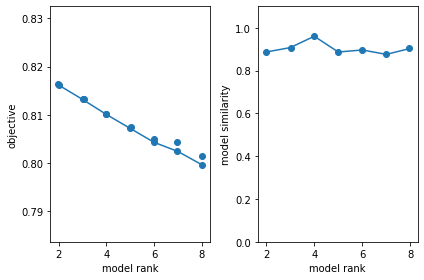

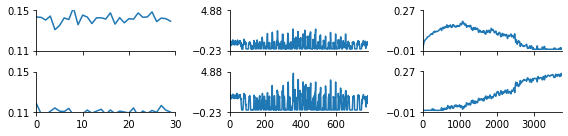

In [21]:
data = weights_data[:,0,...] # ... specify a numpy array holding the tensor you wish to fit
print(data.shape)

# Fit an ensemble of models, 4 random replicates / optimization runs per model rank
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(data, ranks=range(2, 9), replicates=2)

fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

# Plot the low-d factors for an example model, e.g. rank-2, first optimization run / replicate.
num_components = 2
replicate = 0
tt.plot_factors(ensemble.factors(num_components)[replicate])  # plot the low-d factors

plt.show()

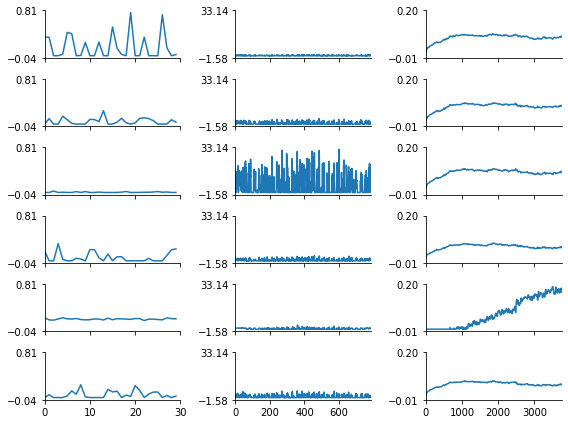

In [25]:
num_components = 6
replicate = 0
tt.plot_factors(ensemble.factors(num_components)[replicate])  # plot the low-d factors

plt.show()

## Factors are stored in the ensemble list, as: (dim, reduced dim)

In [71]:

facts = ensemble.factors(3)[0]
print(facts.factors[1].shape)


(784, 3)


In [72]:
a = weights_data[:,0,...]
a.shape

(30, 784, 3750)

In [73]:
c = np.stack([np.matmul(b.T, facts.factors[1]).T for b in a],axis=0)
c.shape

(30, 3, 3750)

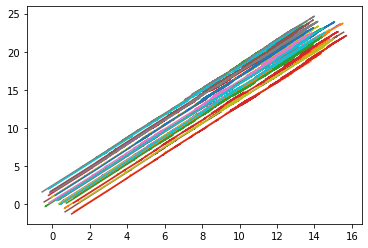

In [77]:
%matplotlib inline
for i in range(num_models):
    plt.plot(c[i,0,:],c[i,1,:])
    

In [ ]:
assert(1==0)

In [ ]:
def make_animation(arr,filename,**kwargs):
    """Take in (w,t) array. Reshape w to 28,28, make animations over t"""
    
    fig = plt.figure()
    ims = []
    for i in range(arr.shape[1]):
        im = plt.imshow(arr[:,i].reshape(28,28), animated=True)
        ims.append([im])
        
    ani = animation.ArtistAnimation(fig, ims, interval=20, blit=True,
                                repeat_delay=1000)
    ani.save(filename +'.gif')
    
def make_animation_all(arr,filename,**kwargs):
    """Take in (class,w,t) array. Reshape w to 28,28, make animations over t"""
    
    fig,ax = plt.subplots(5,2,figsize=(8, 8))
    
    ims = []
    for i in range(arr.shape[1]):
        for j in range(10):
            if j%2==0:
                im =ax[j//2,0].imshow(arr[j,:,i].reshape(28,28), animated=True)
            else:
                im =ax[j//2,1].imshow(arr[j,:,i].reshape(28,28), animated=True)
        ims.append([im])
    
    return ims
#     ani = animation.ArtistAnimation(fig, ims, interval=20, blit=True,
#                                 repeat_delay=1000)
#     ani.save(filename +'.gif')
    
    

In [ ]:
help(ax[0][0])

In [ ]:
print(www.shape)

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots(2,5,figsize=(8, 8))

fps = 30
nSeconds = 5

# im = ax[0][0].imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)
for j in range(10):
    if j%2==0:
        ax[0,j//2].imshow(www[j,:,0].reshape(28,28), animated=True)
        ax[0,j//2].axis('off')
    else:
        ax[1,j//2].imshow(www[j,:,0].reshape(28,28), animated=True)
        ax[1,j//2].axis('off')
        
def animate_func(i):
    
    if i % fps == 0:
        print( '.', end ='' )

    for j in range(10):
        if j%2==0:
            ax[0,j//2].imshow(www[j,:,i].reshape(28,28))
            
            ax[0,j//2].axis('off')
        else:
            ax[1,j//2].imshow(www[j,:,i].reshape(28,28))
        if j == 0:
            ax[0,0].imshow(np.random.random((28,28)))
#             ax[1,j//2].axis('off')
    ax[0,0].set_title('Frame {}'.format(i))
    print(i)
    return [ax]


anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = 10000,
                               interval = 100, # in ms
                               )


In [ ]:
ims = make_animation_all(www,'test4')

# ani = animation.ArtistAnimation(fig, ims, interval=5, blit=True,
#                                 repeat_delay=1000)

# ani.save('test4.mp4')

# plt.show()

In [ ]:
ani = animation.ArtistAnimation(fig, ims, interval=5, blit=True,
                                repeat_delay=1000)

ani.save('test4.gif')

# HERE


In [ ]:
%matplotlib inline

In [ ]:
# Plot the low-d factors for an example model, e.g. rank-2, first optimization run / replicate.
num_components = 2
replicate = 0
tt.plot_factors(ensemble.factors(num_components)[replicate])  # plot the low-d factors

plt.show()

In [ ]:

fig,ax = plt.subplots(2,5,figsize=(8, 8))
    
ims = []
for i in range(www.shape[1]):
    print(i)
    for j in range(10):
        if j%2==0:
            im =ax[0,j//2].imshow(www[j,:,i].reshape(28,28), animated=True)
        else:
            im =ax[1,j//2].imshow(www[j,:,i].reshape(28,28), animated=True)
    ims.append([im])
    
print()

In [ ]:
ims[0]

In [ ]:
# fig = px.imshow(a)

#Iterate through time, make animation
print(www.shape)



In [ ]:
a = weights[1][i].cpu().reshape((28,28))

In [ ]:
a

In [ ]:
plt.imshow(a)

In [ ]:
u = np.linspace(-8, 8, 100)
x, y = np.meshgrid(u, u)
r = np.sqrt(x**2+y**2)

t = np.linspace(0, np.pi*2, 37)
z = np.array([(np.cos(r + s) * np.exp(-r/5)) for s in t])
zmin = np.min(z)
zmax = np.max(z)

In [ ]:
ice = [[0.0, 'rgb(3, 5, 18)'],#cmocean
        [0.11, 'rgb(27, 26, 54)'],
        [0.22, 'rgb(48, 46, 95)'],
        [0.33, 'rgb(60, 66, 136)'],
        [0.44, 'rgb(62, 93, 168)'],
        [0.56, 'rgb(66, 122, 183)'],
        [0.67, 'rgb(82, 149, 192)'],
        [0.78, 'rgb(106, 177, 203)'],
        [0.89, 'rgb(140, 203, 219)'],
        [1, 'rgb(188, 227, 235)']
         ]

In [ ]:
data=[dict(type='surface',
           x=x, 
           y=y, 
           z=np.cos(r) * np.exp(-r/5),
           colorscale=ice, 
           showscale=False,
          )]

data_w = go.Heatmap(z=a,colorscale=ice)
data2 = [dict(type='image',
           x=x, 
           y=y, 
           colorscale=ice, 
           showscale=False,
          )]

In [ ]:
axis = dict(showbackground=True, 
            backgroundcolor="rgb(230, 230,230)",
            gridcolor="rgb(255, 255, 255)",      
            zerolinecolor="rgb(255, 255, 255)",  
            )

In [ ]:
frames = [dict(data= [dict(type='surface',
                           z=z[k])], # update only z; x, y are the same as in basic data
               traces= [0],
               name='frame{}'.format(k)       
            ) for k  in  range(t.shape[0])]

In [ ]:
sliders = [dict(steps= [dict(method= 'animate',#Sets the Plotly method to be called when the
                                                #slider value is changed.
                           args= [[ 'frame{}'.format(k) ],#Sets the arguments values to be passed to 
                                                              #the Plotly method set in method on slide
                                  dict(mode= 'immediate',
                                  frame= dict( duration=50, redraw= False ),
                                           transition=dict( duration= 0)
                                          )
                                    ],
                            label='{:.2f}'.format(t[k])
                             ) for k in range(t.shape[0])], 
                transition= dict(duration= 0 ),
                x=0,#slider starting position  
                y=0, 
                currentvalue=dict(font=dict(size=12), 
                                  prefix='Time: ', 
                                  visible=True, 
                                  xanchor= 'center'
                                 ),  
                len=1.0)#slider length)
           ]

In [ ]:
layout = dict(title='Animating a 2d wave',
              autosize=False,
              width=600,
              height=600,
              showlegend=False,
              scene=dict(camera = dict(eye=dict(x=1.25, y=0.9, z=1.1)),
              aspectratio=dict(x=1, y=1, z=0.5),
              #xaxis=dict(axis),
              #yaxis=dict(axis), 
              zaxis_range=[zmin, zmax]),
               
              updatemenus=[dict(type='buttons', showactive=False,
                                y=0,
                                x=1.15,
                                xanchor='right',
                                yanchor='top',
                                pad=dict(t=0, r=10),
                                buttons=[dict(label='Play',
                                              method='animate',
                                              args=[None, 
                                                    dict(frame=dict(duration=20, 
                                                                    redraw=True),
                                                         transition=dict(duration=0),
                                                         fromcurrent=True,
                                                         mode='immediate'
                                                        )
                                                   ]
                                             )
                                        ]
                               )
                          ],
              sliders=sliders
    
)

In [ ]:
fig = go.Figure(data=data, layout=layout, frames=frames)
fig.show()

In [ ]:


fig = go.Figure(data_w)
fig.show()

for i in range(10):
    fig.update(data=[go.Heatmap(z=np.random.rand(28,28))])

In [ ]:
import random

In [ ]:
N = 50
M = np.random.random((N, 10, 10))

fig = go.Figure(
    data=[go.Heatmap(z=a)],
    layout=go.Layout(
        title="Frame 0",
        title_x=0.5,
        updatemenus=[dict(buttons = [dict(
                                               args = [None, {"frame": {"duration": 50, 
                                                                        "redraw": False},
                                                              "fromcurrent": True, 
                                                              "transition": {"duration": 0}}],
                                               label = "Play",
                                               method = "animate")],
                                type='buttons',
                                showactive=False,
                                y=1,
                                x=1.12,
                                xanchor='right',
                                yanchor='top')]))
    
frames=[go.Frame(data=[go.Heatmap(z=np.random.rand(10,10))]) for i in range(1,100)] 
# frames= [go.Frame(data=[go.Scatter(y=y[:i])]) for i in range(1, 100)]

fig.update(frames=frames)
fig.show()

In [ ]:
y=np.arange(100)     
fig=go.Figure(go.Scatter(y=y[:1], mode='lines', name='Testing Points'))
fig.update_layout(title='Animation Test',
                  title_x=0.5,
                  width=600, height=600, 
                  xaxis_title='Time', 
                  yaxis_title='Test Points',
                  yaxis_range=(0,99),
                  xaxis_range=(0,99), #you generate y-values for i =0, ...99, 
                                      #that are assigned, by default, to x-values 0, 1, ..., 99
                  
                  updatemenus=[dict(buttons = [dict(
                                               args = [None, {"frame": {"duration": 50, 
                                                                        "redraw": False},
                                                              "fromcurrent": True, 
                                                              "transition": {"duration": 0}}],
                                               label = "Play",
                                               method = "animate")],
                                type='buttons',
                                showactive=False,
                                y=1,
                                x=1.12,
                                xanchor='right',
                                yanchor='top')])
                                          
                    
frames= [go.Frame(data=[go.Scatter(y=y[:i])]) for i in range(1, 100)]
fig.update(frames=frames)

fig.show()

In [ ]:
trace = dict(type='heatmapgl', z=a, colorscale='Picnic')
data = [trace]

layout = dict(width=700, height=700)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic heatmapgl')

In [ ]:
import plotly.plotly as py

In [ ]:

N = 1000
M = 500
xx = np.arange(N, dtype=np.float64)
yy = np.arange(M, dtype=np.float64)
x, y = np.meshgrid(xx, yy)
b = N/20.0
c = M/2.0
r = np.sqrt(((x-c)/b)**2 + ((y-c)/b)**2)
a = np.sin(r)

# Limits
xmin = xx[0]
xmax = xx[-1]
ymin = yy[0]
ymax = yy[-1]
amin = np.amin(a)
amax = np.amax(a)

from PIL import Image
from matplotlib import cm
from matplotlib.colors import Normalize

# Some normalization from matplotlib
cNorm = Normalize(vmin=amin, vmax=amax)
scalarMap  = cm.ScalarMappable(norm=cNorm, cmap='viridis' )
seg_colors = scalarMap.to_rgba(a) 
img = Image.fromarray(np.uint8(seg_colors*255))

# Now the plotly code
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Constants
img_width = 900
img_height = 600

# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
# We also add a color to the scatter points so we can have a colorbar next to our image
fig.add_trace(
    go.Scatter(
        x=[xmin, xmax],
        y=[ymin, ymax],
        mode="markers",
        marker={"color":[np.amin(a), np.amax(a)],
                "colorscale":'Viridis',
                "showscale":True,
                "colorbar":{"title":"Counts",
                            "titleside": "right"},
                "opacity": 0
               }
    )
)

# Add image
fig.update_layout(
    images=[go.layout.Image(
        x=xmin,
        sizex=xmax-xmin,
        y=ymax,
        sizey=ymax-ymin,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img)]
)

# Configure other layout
fig.update_layout(
        xaxis=dict(showgrid=False, zeroline=False, range=[xmin, xmax]),
        yaxis=dict(showgrid=False, zeroline=False, range=[ymin, ymax]),
    width=img_width,
    height=img_height,
)

fig.show()